#### 09 Pytorch model deployment

In [1]:
import torchvision
import torch

In [2]:
# Continue with regular imports
import matplotlib.pyplot as plt
import torch
import torchvision

from torch import nn
from torchvision import transforms

# Try to get torchinfo, install it if it doesn't work
try:
    from torchinfo import summary
except:
    print("[INFO] Couldn't find torchinfo... installing it.")
    !pip install -q torchinfo
    from torchinfo import summary

# Try to import the going_modular directory, download it from GitHub if it doesn't work
try:
    from going_modular.going_modular import data_setup, engine
    from helper_functions import download_data, set_seeds, plot_loss_curves
except:
    # Get the going_modular scripts
    print("[INFO] Couldn't find going_modular or helper_functions scripts... downloading them from GitHub.")
    !git clone https://github.com/mrdbourke/pytorch-deep-learning
    !mv pytorch-deep-learning/going_modular .
    !mv pytorch-deep-learning/helper_functions.py . # get the helper_functions.py script
    !rm -rf pytorch-deep-learning
    from going_modular.going_modular import data_setup, engine
    from helper_functions import download_data, set_seeds, plot_loss_curves

[INFO] Couldn't find torchinfo... installing it.
[INFO] Couldn't find going_modular or helper_functions scripts... downloading them from GitHub.
Cloning into 'pytorch-deep-learning'...
remote: Enumerating objects: 4056, done.
remote: Total 4056 (delta 0), reused 0 (delta 0), pack-reused 4056
Receiving objects: 100% (4056/4056), 646.90 MiB | 33.99 MiB/s, done.
Resolving deltas: 100% (2371/2371), done.
Updating files: 100% (248/248), done.


In [17]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [4]:
# Download pizza, steak, sushi images from GitHub
data_20_percent_path = download_data(source="https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi_20_percent.zip",
                                     destination="pizza_steak_sushi_20_percent")

data_20_percent_path

[INFO] Did not find data/pizza_steak_sushi_20_percent directory, creating one...
[INFO] Downloading pizza_steak_sushi_20_percent.zip from https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi_20_percent.zip...
[INFO] Unzipping pizza_steak_sushi_20_percent.zip data...


PosixPath('data/pizza_steak_sushi_20_percent')

In [5]:
# Setup directory paths to train and test images
train_dir = data_20_percent_path / "train"
test_dir = data_20_percent_path / "test"

In [6]:
# creating an effNetb2 model
weights_effnetB2 = torchvision.models.EfficientNet_B2_Weights.DEFAULT
model_effnetB2 = torchvision.models.efficientnet_b2(weights=weights_effnetB2)

Downloading: "https://download.pytorch.org/models/efficientnet_b2_rwightman-c35c1473.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b2_rwightman-c35c1473.pth
100%|██████████| 35.2M/35.2M [00:00<00:00, 147MB/s]


In [7]:
weights_vit_b_16 = torchvision.models.ViT_B_16_Weights.DEFAULT
model_vit_b_16 = torchvision.models.vit_b_16(weights=weights_vit_b_16)

Downloading: "https://download.pytorch.org/models/vit_b_16-c867db91.pth" to /root/.cache/torch/hub/checkpoints/vit_b_16-c867db91.pth
100%|██████████| 330M/330M [00:02<00:00, 122MB/s]


In [8]:
train_dataloader_eff, test_dataloader_eff,class_names = data_setup.create_dataloaders(
    train_dir = train_dir,
    test_dir = test_dir,
    batch_size=32,
    transform = weights_effnetB2.transforms(),
)
train_dataloader_vit, test_dataloader_vit,_ = data_setup.create_dataloaders(
    train_dir = train_dir,
    test_dir = test_dir,
    batch_size = 32,
    transform = weights_vit_b_16.transforms(),
)

In [9]:
next(iter(train_dataloader_vit))[0].shape

torch.Size([32, 3, 224, 224])

In [10]:
# using torchinfo view model summary
from torchinfo import summary

# summary(model=model_effnetB2,
#         input_size=(1,3, 288, 288),
#         col_names=["input_size","output_size", "num_params","trainable"],
#         col_width=20,
#         row_settings=["var_names"])


In [11]:
# freezing all the layers except the head of the model
model_effnetB2.classifier
for param in model_effnetB2.parameters():
  param.requires_grad = False
model_effnetB2.classifier = nn.Sequential(
    nn.Dropout(p=0.3, inplace=True),
    nn.Linear(in_features=1408, out_features=3, bias=True)
)

# summary(model=model_effnetB2,
#         input_size=(1,3, 288, 288),
#         col_names=["input_size","output_size", "num_params","trainable"],
#         col_width=20,
#         row_settings=["var_names"])

In [12]:
# using torchinfo view model summary
from torchinfo import summary

# summary(model=model_vit_b_16,
#         input_size=(1, 3, 224, 224),
#         col_names=["input_size","output_size", "num_params","trainable"],
#         col_width=20,
#         row_settings=["var_names"])

In [13]:
model_vit_b_16.heads
for param in model_vit_b_16.parameters():
  param.requires_grad = False
model_vit_b_16.heads = nn.Linear(in_features=768, out_features=3, bias=True)

In [14]:
# using torchinfo view model summary
from torchinfo import summary

# summary(model=model_vit_b_16,
#         input_size=(1, 3, 224, 224),
#         col_names=["input_size","output_size", "num_params","trainable"],
#         col_width=20,
#         row_settings=["var_names"])

In [15]:
loss_fn = nn.CrossEntropyLoss()
set_seeds()
optimizer = torch.optim.Adam(params =model_effnetB2.parameters(), lr = 1e-3 )
result_effnetb2_10 = engine.train(
    model = model_effnetB2,
    train_dataloader = train_dataloader_eff,
    test_dataloader = test_dataloader_eff,
    loss_fn = loss_fn,
    optimizer = optimizer,
    device =device,
    epochs = 10
)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.9803 | train_acc: 0.5604 | test_loss: 0.7546 | test_acc: 0.9136
Epoch: 2 | train_loss: 0.7064 | train_acc: 0.8354 | test_loss: 0.6078 | test_acc: 0.9290
Epoch: 3 | train_loss: 0.5832 | train_acc: 0.9104 | test_loss: 0.5057 | test_acc: 0.9472
Epoch: 4 | train_loss: 0.4522 | train_acc: 0.9062 | test_loss: 0.4436 | test_acc: 0.9381
Epoch: 5 | train_loss: 0.4260 | train_acc: 0.9104 | test_loss: 0.4055 | test_acc: 0.9290
Epoch: 6 | train_loss: 0.4378 | train_acc: 0.8938 | test_loss: 0.3633 | test_acc: 0.9534
Epoch: 7 | train_loss: 0.4228 | train_acc: 0.8375 | test_loss: 0.3382 | test_acc: 0.9472
Epoch: 8 | train_loss: 0.3878 | train_acc: 0.8604 | test_loss: 0.3539 | test_acc: 0.9108
Epoch: 9 | train_loss: 0.3800 | train_acc: 0.8792 | test_loss: 0.3211 | test_acc: 0.9102
Epoch: 10 | train_loss: 0.3664 | train_acc: 0.8667 | test_loss: 0.2876 | test_acc: 0.9625


In [16]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params =model_vit_b_16.parameters(), lr = 1e-3 )
result_vit_16_b = engine.train(
    model = model_vit_b_16,
    train_dataloader = train_dataloader_vit,
    test_dataloader = test_dataloader_vit,
    loss_fn = loss_fn,
    optimizer = optimizer,
    device =device,
    epochs = 10
)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.5720 | train_acc: 0.8333 | test_loss: 0.2392 | test_acc: 0.9443
Epoch: 2 | train_loss: 0.2285 | train_acc: 0.9479 | test_loss: 0.1277 | test_acc: 0.9875
Epoch: 3 | train_loss: 0.1461 | train_acc: 0.9604 | test_loss: 0.0998 | test_acc: 0.9938
Epoch: 4 | train_loss: 0.1313 | train_acc: 0.9646 | test_loss: 0.0845 | test_acc: 0.9938
Epoch: 5 | train_loss: 0.1044 | train_acc: 0.9729 | test_loss: 0.0759 | test_acc: 0.9875
Epoch: 6 | train_loss: 0.0909 | train_acc: 0.9750 | test_loss: 0.0687 | test_acc: 0.9875
Epoch: 7 | train_loss: 0.0774 | train_acc: 0.9812 | test_loss: 0.0655 | test_acc: 0.9875
Epoch: 8 | train_loss: 0.0689 | train_acc: 0.9833 | test_loss: 0.0609 | test_acc: 0.9875
Epoch: 9 | train_loss: 0.0604 | train_acc: 0.9854 | test_loss: 0.0583 | test_acc: 0.9875
Epoch: 10 | train_loss: 0.0615 | train_acc: 0.9917 | test_loss: 0.0566 | test_acc: 0.9875


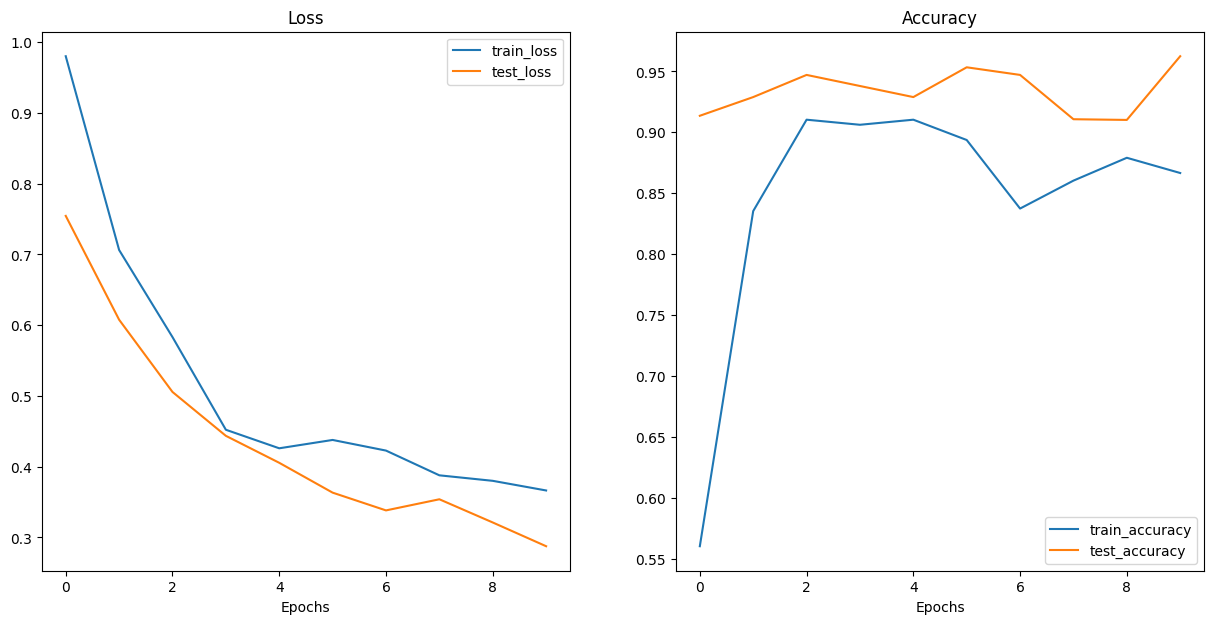

In [17]:
from helper_functions import plot_loss_curves

plot_loss_curves(result_effnetb2_10)

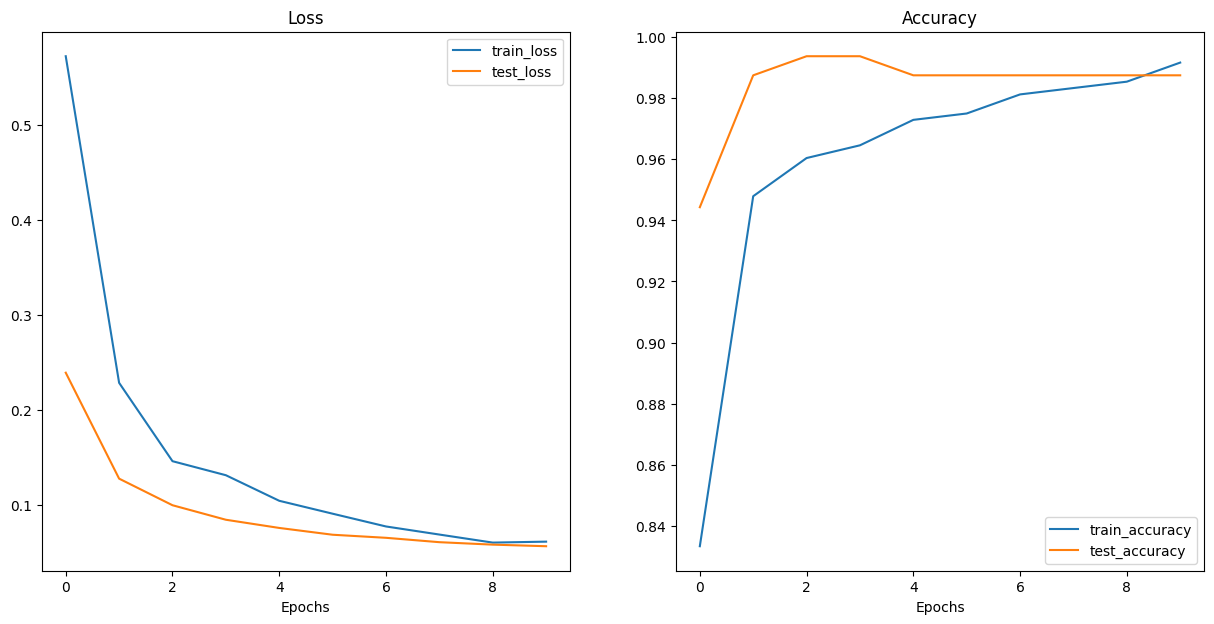

In [18]:
plot_loss_curves(result_vit_16_b)

In [19]:
# saving both models
from going_modular.going_modular.utils import save_model
# saving the
save_model(
    model = model_effnetB2,
    target_dir = "models",
    model_name = "model_effnetB2.pth"
)


[INFO] Saving model to: models/model_effnetB2.pth


In [20]:
save_model(
    model = model_vit_b_16,
    target_dir = "models",
    model_name = "model_vit_b_16.pth"
)

[INFO] Saving model to: models/model_vit_b_16.pth


In [21]:
from pathlib import Path
effnetB2_size = Path("models/model_effnetB2.pth").stat().st_size//(1024*1024)
vit_b_16_size = Path("models/model_vit_b_16.pth").stat().st_size//(1024*1024)
print(f" <-MODEL SIZES->\n Effnet_b2: {effnetB2_size}MB \n ViT_b_16: {vit_b_16_size}MB")

 <-MODEL SIZES->
 Effnet_b2: 29MB 
 ViT_b_16: 327MB


#### Making predictions with out trained models and timing them
our goal:
1. Performs well (95%+ test accuracy)
2. Fast(30+FPS)

To test criteria:
1. Loop through test images
2. Time how long each model takes to make a prediction on the image


In [22]:
from pathlib import Path

test_data_paths = list(Path(test_dir).glob("*/*.jpg"))
test_data_paths[:5]

[PosixPath('data/pizza_steak_sushi_20_percent/test/pizza/724290.jpg'),
 PosixPath('data/pizza_steak_sushi_20_percent/test/pizza/2250611.jpg'),
 PosixPath('data/pizza_steak_sushi_20_percent/test/pizza/833711.jpg'),
 PosixPath('data/pizza_steak_sushi_20_percent/test/pizza/296426.jpg'),
 PosixPath('data/pizza_steak_sushi_20_percent/test/pizza/3486640.jpg')]

In [23]:
from pathlib import Path
from timeit import default_timer as timer
from tqdm.auto import tqdm
from typing import Dict, List
import torch
import PIL

def pred_and_store(
    paths:List[Path],
    model:torch.nn.Module,
    transforms:torchvision.transforms,
    class_names: List[str],
    device:str="cuda" if torch.cuda.is_available() else "cpu"
    ) ->List[Dict]:
    pred_list = []
    for path in tqdm(paths):
      pred_dict = {}
      pred_dict["image_path"] = path
      class_name = path.parent.stem
      pred_dict["class_name"] = class_name
      start_time = timer()
      img = PIL.Image.open(path)
      transformed_image = transforms(img).unsqueeze(0).to(device)
      model.to(device)
      model.eval()
      with torch.inference_mode():
        pred_logits = model(transformed_image)
        pred_prob = torch.softmax(pred_logits, dim=1)
        pred_label = torch.argmax(pred_prob,dim=1)
        pred_class = class_names[pred_label.cpu()]
        pred_dict["pred_prob"] = round(pred_prob.unsqueeze(0).max().cpu().item(),4)
        pred_dict["pred_class"]  = pred_class
        end_time = timer()
        pred_dict["time_fot_pred"] = round(end_time-start_time,4)
      pred_dict["correct"] = class_name == pred_class
      pred_list.append(pred_dict)
    return pred_list

In [24]:
# Models
# model_vit_b_16
# model_effnetB2


vit_b_16_data = pred_and_store(
    paths=test_data_paths,
    model=model_vit_b_16,
    transforms = weights_vit_b_16.transforms(),
    class_names = class_names,
    device="cpu"
    )

eff_net_data = pred_and_store(
    paths= test_data_paths,
    model = model_effnetB2,
    transforms = weights_effnetB2.transforms(),
    class_names = class_names,
    device="cpu"

)

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

In [25]:
import pandas as pd
effnetb2_test_pred_df = pd.DataFrame(eff_net_data)
effnetb2_test_pred_df.head()

,image_path,class_name,pred_prob,pred_class,time_fot_pred,correct
0,data/pizza_steak_sushi_20_percent/test/pizza/7...,pizza,0.7567,pizza,0.1545,True
1,data/pizza_steak_sushi_20_percent/test/pizza/2...,pizza,0.8510,pizza,0.1288,True
2,data/pizza_steak_sushi_20_percent/test/pizza/8...,pizza,0.6180,pizza,0.1075,True
3,data/pizza_steak_sushi_20_percent/test/pizza/2...,pizza,0.8335,pizza,0.1070,True
4,data/pizza_steak_sushi_20_percent/test/pizza/3...,pizza,0.9754,pizza,0.1025,True


In [26]:
effnetb2_avarage_time = round(effnetb2_test_pred_df.time_fot_pred.mean(),4)
print(f"Effnetb2 Average time for prediction: {effnetb2_avarage_time} seconds")

Effnetb2 Average time for prediction: 0.1116 seconds


In [27]:
viteb16_test_pred_df = pd.DataFrame(vit_b_16_data)
viteb16_test_pred_df.head()

,image_path,class_name,pred_prob,pred_class,time_fot_pred,correct
0,data/pizza_steak_sushi_20_percent/test/pizza/7...,pizza,0.9961,pizza,0.8966,True
1,data/pizza_steak_sushi_20_percent/test/pizza/2...,pizza,0.9987,pizza,0.5373,True
2,data/pizza_steak_sushi_20_percent/test/pizza/8...,pizza,0.9987,pizza,0.5387,True
3,data/pizza_steak_sushi_20_percent/test/pizza/2...,pizza,0.9985,pizza,0.5286,True
4,data/pizza_steak_sushi_20_percent/test/pizza/3...,pizza,0.9981,pizza,0.5210,True


In [28]:
viteb16_avarage_time = round(viteb16_test_pred_df.time_fot_pred.mean(),4)
print(f"ViT Average time for prediction:{viteb16_avarage_time}")

ViT Average time for prediction:0.601


In [29]:
try:
  import gradio as gr
except:
  !pip install gradio
  import gradio as gr
print(f"Gradio Version:{gr.__version__}")

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.3/12.3 MB 52.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 92.0/92.0 kB 16.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 315.9/315.9 kB 46.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.6/75.6 kB 14.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 142.5/142.5 kB 24.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.8/8.8 MB 49.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.2/47.2 kB 8.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.8/60.8 kB 8.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.9/129.9 kB 16.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 14.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 10.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 71.9/71.9 kB 12.9 MB

In [30]:
# putting mode on cpu
model_effnetB2 = model_effnetB2.to("cpu")


In [31]:
from typing import Tuple, Dict
def predict(img) -> Tuple[Dict, float]:
  start_timer = timer()
  transforms = weights_effnetB2.transforms()
  img = transforms(img).unsqueeze(0)
  model_effnetB2.eval()
  with torch.inference_mode():
    pred_probs = torch.softmax(model_effnetB2(img),dim=1)
    print(pred_probs)
    pred_labels_and_probs = dict(zip(class_names,pred_probs[0].numpy()))
  stop_timer = timer()

  pred_time = round(stop_timer-start_timer,4)

  return pred_labels_and_probs,pred_time

[INFO] Predicting on image at path data/pizza_steak_sushi_20_percent/test/pizza/380739.jpg

tensor([[0.9557, 0.0128, 0.0315]])
Pred Dict:{'pizza': 0.9557005, 'steak': 0.012763166, 'sushi': 0.031536296}
Pred_time:0.1182 Seconds


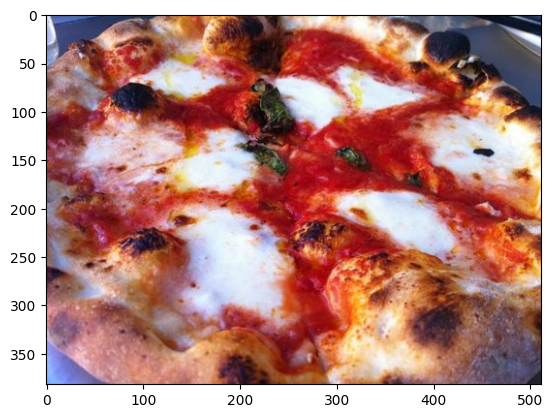

In [32]:
import random
from PIL import Image
test_data_paths = list(Path(test_dir).glob("*/*.jpg"))
test_data_paths[0]
# selecting a ranodm image
random_image_path = random.choice(test_data_paths)

image = Image.open(random_image_path)
print(f"[INFO] Predicting on image at path {random_image_path}\n")

# predict on target image and print output
pred_dict, pred_time = predict(img=image)
print(f"Pred Dict:{pred_dict}")
print(f"Pred_time:{pred_time} Seconds")
plt.imshow(image)


In [33]:
# creating a list of example images
example_list = [[str(fp)] for fp in random.sample(test_data_paths,k=3)]
example_list

[['data/pizza_steak_sushi_20_percent/test/pizza/380739.jpg'],
 ['data/pizza_steak_sushi_20_percent/test/steak/3553838.jpg'],
 ['data/pizza_steak_sushi_20_percent/test/steak/86782.jpg']]

In [34]:
# create title, description
title = "FoodVision Mini 🍕🥩🍣"
description = "An [EfficientNetB2 feature extractor](https://pytorch.org/vision/stable/models/generated/torchvision.models.efficientnet_b2.html#torchvision.models.efficientnet_b2) computer vision model to classify images as pizza, steak or sushi."
article = "Created at [09. practice model deployment](https://colab.research.google.com/drive/1WcQ8tzyhDfppQZG1_2mi7iGpjY8Xi__p?usp=sharing)"

demo  = gr.Interface(fn=predict,
                     inputs=gr.Image(type="pil"),
                     outputs=[gr.Label(num_top_classes=3, label="predictions"),
                              gr.Number(label="Prediction time (s)")],
                     examples = example_list,
                     title=title,
                     description=description,
                     article = article
                     )
demo.launch(debug=False,
            share=True)

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
Running on public URL: https://d3b6eae110a7315eaf.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from Terminal to deploy to Spaces (https://huggingface.co/spaces)


To upload our demo Gradio app, we'll want to put everything relating to it into a single directory.

For example, our demo might live at the path demos/foodvision_mini/ with the file structure:

```
demos/
└── foodvision_mini/
    ├── 09_pretrained_effnetb2_feature_extractor_pizza_steak_sushi_20_percent.pth
    ├── app.py
    ├── examples/
    │   ├── example_1.jpg
    │   ├── example_2.jpg
    │   └── example_3.jpg
    ├── model.py
    └── requirements.txt
```

In [35]:
# turning the application to deployable instance
# will host on hugging face spaces
# creating a demos folder
import shutil
from pathlib import Path
# creating the food_vidion_min demo_path
food_vision_mini_demo_path = Path("demos/foodvision_mini/")
if (food_vision_mini_demo_path.exists()):
  shutil.rmtree(food_vision_mini_demo_path)
  food_vision_mini_demo_path.mkdir(parents=True,
                                   exist_ok= True)
else:
  food_vision_mini_demo_path.mkdir(parents=True,
                                   exist_ok= True)
!ls /demos

ls: cannot access '/demos': No such file or directory


In [36]:
# creating folder of exmpleimages
import shutil
from pathlib import Path
food_vision_examples_path = food_vision_mini_demo_path/"examples"
food_vision_examples_path.mkdir(parents=True, exist_ok=True)

foodvision_mini_examples = [Path('data/pizza_steak_sushi_20_percent/test/sushi/592799.jpg'),
                            Path('data/pizza_steak_sushi_20_percent/test/steak/3622237.jpg'),
                            Path('data/pizza_steak_sushi_20_percent/test/pizza/2582289.jpg')]

# 3. Copy the three random images to the examples directory
for example in foodvision_mini_examples:
    destination = food_vision_examples_path / example.name
    print(f"[INFO] Copying {example} to {destination}")
    shutil.copy2(src=example, dst=destination)

[INFO] Copying data/pizza_steak_sushi_20_percent/test/sushi/592799.jpg to demos/foodvision_mini/examples/592799.jpg
[INFO] Copying data/pizza_steak_sushi_20_percent/test/steak/3622237.jpg to demos/foodvision_mini/examples/3622237.jpg
[INFO] Copying data/pizza_steak_sushi_20_percent/test/pizza/2582289.jpg to demos/foodvision_mini/examples/2582289.jpg


In [37]:
import os
# get examples as list
example_list = [["examples/"+example] for example in os.listdir(food_vision_examples_path)]

In [38]:
# moving the mode
import shutil

effneb2_fvm_model_path = "models/model_effnetB2.pth"
effneb2_fvm_model_destination = food_vision_mini_demo_path/effneb2_fvm_model_path.split("/")[1]
effneb2_fvm_model_destination
try:
  print(f"[INFO] Attempting to move from {effneb2_fvm_model_path} to {effneb2_fvm_model_destination}")
  shutil.move(
      src=Path(effneb2_fvm_model_path),
      dst = effneb2_fvm_model_destination
  )
except:
  print(f"[INFO]: No model found at the source")



[INFO] Attempting to move from models/model_effnetB2.pth to demos/foodvision_mini/model_effnetB2.pth


In [39]:
%%writefile demos/foodvision_mini/model.py
import torch
import torchvision

from torch import nn


def create_effnetb2_model(num_classes:int=3,
                          seed:int=42):
    """Creates an EfficientNetB2 feature extractor model and transforms.

    Args:
        num_classes (int, optional): number of classes in the classifier head.
            Defaults to 3.
        seed (int, optional): random seed value. Defaults to 42.

    Returns:
        model (torch.nn.Module): EffNetB2 feature extractor model.
        transforms (torchvision.transforms): EffNetB2 image transforms.
    """
    # Create EffNetB2 pretrained weights, transforms and model
    weights = torchvision.models.EfficientNet_B2_Weights.DEFAULT
    transforms = weights.transforms()
    model = torchvision.models.efficientnet_b2(weights=weights)

    # Freeze all layers in base model
    for param in model.parameters():
        param.requires_grad = False

    # Change classifier head with random seed for reproducibility
    torch.manual_seed(seed)
    model.classifier = nn.Sequential(
        nn.Dropout(p=0.3, inplace=True),
        nn.Linear(in_features=1408, out_features=num_classes),
    )

    return model, transforms

Writing demos/foodvision_mini/model.py


In [40]:
%%writefile demos/foodvision_mini/app.py
### 1. Imports and class names setup ###
import gradio as gr
import os
import torch

from model import create_effnetb2_model
from timeit import default_timer as timer
from typing import Tuple, Dict

# Setup class names
class_names = ["pizza", "steak", "sushi"]

### 2. Model and transforms preparation ###

# Create EffNetB2 model
effnetb2, effnetb2_transforms = create_effnetb2_model(
    num_classes=3, # len(class_names) would also work
)

# Load saved weights
effnetb2.load_state_dict(
    torch.load(
        f="model_effnetB2.pth",
        map_location=torch.device("cpu"),  # load to CPU
    )
)

### 3. Predict function ###

# Create predict function
def predict(img) -> Tuple[Dict, float]:
    """Transforms and performs a prediction on img and returns prediction and time taken.
    """
    # Start the timer
    start_time = timer()

    # Transform the target image and add a batch dimension
    img = effnetb2_transforms(img).unsqueeze(0)

    # Put model into evaluation mode and turn on inference mode
    effnetb2.eval()
    with torch.inference_mode():
        # Pass the transformed image through the model and turn the prediction logits into prediction probabilities
        pred_probs = torch.softmax(effnetb2(img), dim=1)

    # Create a prediction label and prediction probability dictionary for each prediction class (this is the required format for Gradio's output parameter)
    pred_labels_and_probs = {class_names[i]: float(pred_probs[0][i]) for i in range(len(class_names))}

    # Calculate the prediction time
    pred_time = round(timer() - start_time, 5)

    # Return the prediction dictionary and prediction time
    return pred_labels_and_probs, pred_time

### 4. Gradio app ###

# Create title, description and article strings
title = "FoodVision Mini 🍕🥩🍣"
description = "An EfficientNetB2 feature extractor computer vision model to classify images of food as pizza, steak or sushi."
article = "Created at [09. PyTorch Model Deployment](https://www.learnpytorch.io/09_pytorch_model_deployment/)."

# Create examples list from "examples/" directory
example_list = [["examples/" + example] for example in os.listdir("examples")]

# Create the Gradio demo
demo = gr.Interface(fn=predict, # mapping function from input to output
                    inputs=gr.Image(type="pil"), # what are the inputs?
                    outputs=[gr.Label(num_top_classes=3, label="Predictions"), # what are the outputs?
                             gr.Number(label="Prediction time (s)")], # our fn has two outputs, therefore we have two outputs
                    # Create examples list from "examples/" directory
                    examples=example_list,
                    title=title,
                    description=description,
                    article=article)

# Launch the demo!
demo.launch()

Writing demos/foodvision_mini/app.py


In [41]:
%%writefile demos/foodvision_mini/requirements.txt
torch==2.3.9
torchvision==0.18.0
gradio==4.31.5

Writing demos/foodvision_mini/requirements.txt


In [42]:
# experimenting cell
torch.__version__, torchvision.__version__, gr.__version__

('2.3.0+cu121', '0.18.0+cu121', '4.31.5')

In [43]:
!ls demos/foodvision_mini/

app.py	examples  model_effnetB2.pth  model.py	requirements.txt


In [44]:
# deploying the application to huggingface spaces
!cd demos/foodvision_mini && zip -4 ../foodvision_mini.zip * -x "*.pyc" "*ipynb" "*__pycache__" "*ipynb_checkpoints*"

  adding: app.py (deflated 56%)
  adding: examples/ (stored 0%)
  adding: model_effnetB2.pth (deflated 8%)
  adding: model.py (deflated 55%)
  adding: requirements.txt (deflated 2%)


In [45]:
!cd ..


In [46]:
!ls

data  demos  flagged  going_modular  helper_functions.py  models  __pycache__  sample_data


In [47]:
try:
  from google.colab import files
  files.download("demos/foodvision_mini.zip")
except:
  print("Not running colab, can't use google.colab.files.download(), please download manually")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [48]:
from IPython.display import IFrame
IFrame(src="https://blesspearl-food-vision-practice.hf.space",width=900, height=750)

### creating food vision big


In [5]:
import torchvision
import torch
from torch import nn
def create_effnetb2_model(num_classes:int=3,
                          seed:int=42):
    """Creates an EfficientNetB2 feature extractor model and transforms.

    Args:
        num_classes (int, optional): number of classes in the classifier head.
            Defaults to 3.
        seed (int, optional): random seed value. Defaults to 42.

    Returns:
        model (torch.nn.Module): EffNetB2 feature extractor model.
        transforms (torchvision.transforms): EffNetB2 image transforms.
    """
    # Create EffNetB2 pretrained weights, transforms and model
    weights = torchvision.models.EfficientNet_B2_Weights.DEFAULT
    transforms = weights.transforms()
    model = torchvision.models.efficientnet_b2(weights=weights)

    # Freeze all layers in base model
    for param in model.parameters():
        param.requires_grad = False

    # Change classifier head with random seed for reproducibility
    torch.manual_seed(seed)
    model.classifier = nn.Sequential(
        nn.Dropout(p=0.3, inplace=True),
        nn.Linear(in_features=1408, out_features=num_classes),
    )

    return model, transforms

In [6]:
model_effnetB2_l,base_transform = create_effnetb2_model(num_classes=101,
                                         seed=42)

train_food_101_transforms = torchvision.transforms.Compose([
    torchvision.transforms.TrivialAugmentWide(),
    base_transform
])



In [7]:
# getting data for foodvision
from torchvision import datasets
from pathlib import Path

data_dir = Path("data")
train_data = datasets.Food101(root=data_dir,
                              split="train",
                              transform=train_food_101_transforms,
                              download=True
                              )
test_data = datasets.Food101(root=data_dir,
                             split="test",
                             transform=base_transform,
                             download=True
                             )

In [8]:
food_101_classes = train_data.classes

In [9]:
# creating a subset from\
from torch.utils.data import random_split
def split_dataset(dataset:torchvision.datasets,
                  split_size:float=0.2,
                  seed:int=42):
  lenght_1 = int(len(dataset)*split_size)
  lenght_2 = int(len(dataset)-lenght_1)
  print(f"[INFO] Splitting dataset of lenght {len(dataset)} inti splits of size {lenght_1} and {lenght_2}")
  random_split_1, random_split_2 = random_split(dataset,
                                                      lengths=[lenght_1, lenght_2],
                                                      generator=torch.manual_seed(seed)
                                                      )
  return random_split_1, random_split_2


In [10]:
train_data_20_percent,_=split_dataset(dataset = train_data)
len(train_data_20_percent)

[INFO] Splitting dataset of lenght 75750 inti splits of size 15150 and 60600


15150

In [11]:
test_data_20_percent,_=split_dataset(dataset = test_data)
len(test_data_20_percent)

[INFO] Splitting dataset of lenght 25250 inti splits of size 5050 and 20200


5050

In [12]:
BATCH_SIZE=32
train_dataloader_l = torch.utils.data.DataLoader(train_data,
    batch_size=BATCH_SIZE,
    shuffle=True, # don't necessarily have to shuffle the testing data,
    num_workers=2
)


test_dataloader_l = torch.utils.data.DataLoader(train_data,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=2  # don't necessarily have to shuffle the testing data
)
len(train_dataloader_l), len(test_dataloader_l)

(2368, 2368)

In [15]:
# creatint the loss function and the optimizer
loss_fn = nn.CrossEntropyLoss(
    label_smoothing=0.1
)
optimizer = torch.optim.Adam(params=model_effnetB2_l.parameters(),lr=0.001)

In [18]:
from going_modular.going_modular import engine
# set_seeds()
torch.manual_seed(42)
torch.cuda.manual_seed(42)

result_effnetB2_l = engine.train(
    model = model_effnetB2_l,
    train_dataloader = train_dataloader_l,
    test_dataloader = test_dataloader_l,
    loss_fn = loss_fn,
    optimizer = optimizer,
    device =device,
    epochs = 5
)

  0%|          | 0/5 [00:00<?, ?it/s]

Batch 2367 of 2368
Epoch: 1 | train_loss: 2.9776 | train_acc: 0.4084 | test_loss: 2.4394 | test_acc: 0.5432
Batch 2367 of 2368
Epoch: 2 | train_loss: 2.6479 | train_acc: 0.4811 | test_loss: 2.3334 | test_acc: 0.5689
Batch 2367 of 2368
Epoch: 3 | train_loss: 2.6156 | train_acc: 0.4900 | test_loss: 2.2779 | test_acc: 0.5885
Batch 2367 of 2368
Epoch: 4 | train_loss: 2.5948 | train_acc: 0.4970 | test_loss: 2.2541 | test_acc: 0.5949
Batch 2367 of 2368
Epoch: 5 | train_loss: 2.5941 | train_acc: 0.4973 | test_loss: 2.2319 | test_acc: 0.6016


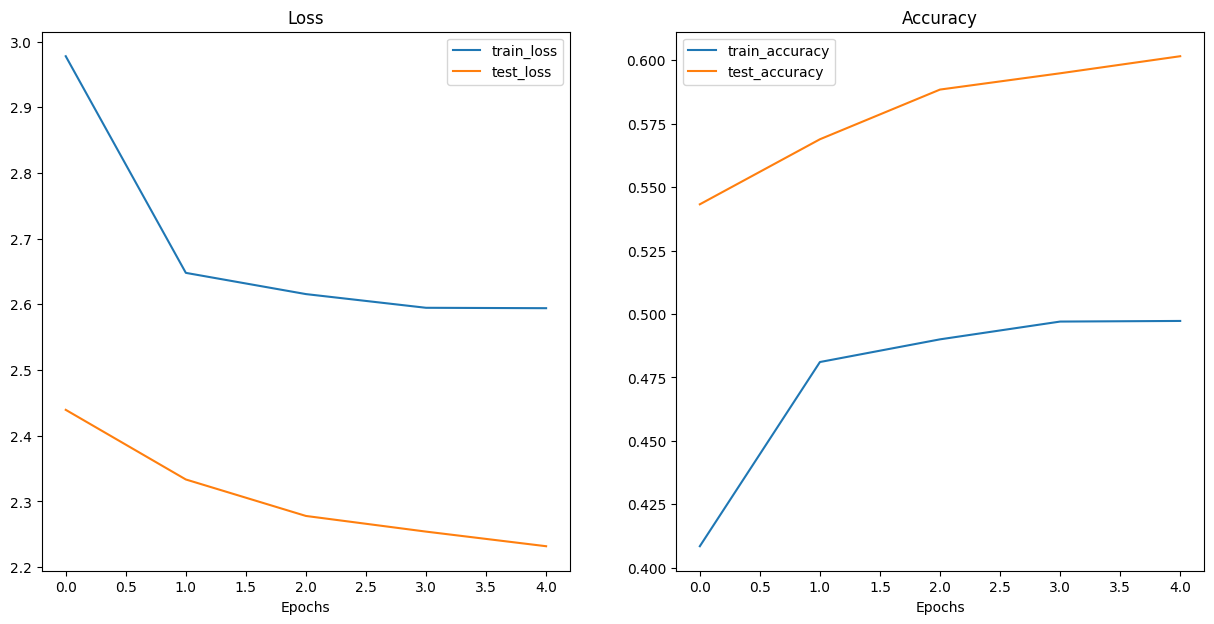

In [20]:
from helper_functions import plot_loss_curves
plot_loss_curves(result_effnetB2_l)


In [19]:
from going_modular.going_modular import utils

model_effnetB2_l_path = "model_effnetB2_101.pth"
utils.save_model(model = model_effnetB2_l,
                 target_dir="models/",
                 model_name=model_effnetB2_l_path)

[INFO] Saving model to: models/model_effnetB2_101.pth


In [21]:
loaded_effnetb2_food_101, effnetb2_transforms = create_effnetb2_model(num_classes=101,
                                         seed=42)
loaded_effnetb2_food_101.load_state_dict(torch.load("models/model_effnetB2_101.pth"))

<All keys matched successfully>

In [22]:
# turing the model into an application
from pathlib import Path
foodvision_big_demo_path = Path("demos/foodvision_big/")
# making the director
foodvision_big_demo_path.mkdir(parents=True,
                              exist_ok=True)

(foodvision_big_demo_path/"examples").mkdir(parents=True,exist_ok=True)



In [23]:
# downloading an image into the
!wget https://github.com/mrdbourke/pytorch-deep-learning/blob/main/images/04-pizza-dad.jpeg?raw=true
!mv 04-pizza-dad.jpeg demos/foodvision_big/examples/04-pizza-dad.jpeg


--2024-05-26 01:50:10--  https://github.com/mrdbourke/pytorch-deep-learning/blob/main/images/04-pizza-dad.jpeg?raw=true
Resolving github.com (github.com)... 140.82.114.4
Connecting to github.com (github.com)|140.82.114.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://github.com/mrdbourke/pytorch-deep-learning/raw/main/images/04-pizza-dad.jpeg [following]
--2024-05-26 01:50:11--  https://github.com/mrdbourke/pytorch-deep-learning/raw/main/images/04-pizza-dad.jpeg
Reusing existing connection to github.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/04-pizza-dad.jpeg [following]
--2024-05-26 01:50:11--  https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/04-pizza-dad.jpeg
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent

In [24]:
!ls
!mv models/model_effnetB2_101.pth demos/foodvision_big/model_effnetB2_101.pth

'04-pizza-dad.jpeg?raw=true'   demos	 going_modular	       models	     sample_data
 data			       flagged	 helper_functions.py   __pycache__


In [25]:
# saving all the classnames to a txt file
foodvision_big_class_names_path = foodvision_big_demo_path/"class_names.txt"
with open(foodvision_big_class_names_path, "w") as f:
    f.write("\n".join(food_101_classes))

In [26]:
with open(foodvision_big_class_names_path, "r") as f:
    foodvision_big_class_names_loaded = [food.strip() for food in f.readlines()]
foodvision_big_class_names_loaded[:10]

['apple_pie',
 'baby_back_ribs',
 'baklava',
 'beef_carpaccio',
 'beef_tartare',
 'beet_salad',
 'beignets',
 'bibimbap',
 'bread_pudding',
 'breakfast_burrito']

In [27]:
%%writefile demos/foodvision_big/model.py
import torch
import torchvision

from torch import nn


def create_effnetb2_model(num_classes:int=3,
                          seed:int=42):
    """Creates an EfficientNetB2 feature extractor model and transforms.

    Args:
        num_classes (int, optional): number of classes in the classifier head.
            Defaults to 3.
        seed (int, optional): random seed value. Defaults to 42.

    Returns:
        model (torch.nn.Module): EffNetB2 feature extractor model.
        transforms (torchvision.transforms): EffNetB2 image transforms.
    """
    # Create EffNetB2 pretrained weights, transforms and model
    weights = torchvision.models.EfficientNet_B2_Weights.DEFAULT
    transforms = weights.transforms()
    model = torchvision.models.efficientnet_b2(weights=weights)

    # Freeze all layers in base model
    for param in model.parameters():
        param.requires_grad = False

    # Change classifier head with random seed for reproducibility
    torch.manual_seed(seed)
    model.classifier = nn.Sequential(
        nn.Dropout(p=0.3, inplace=True),
        nn.Linear(in_features=1408, out_features=num_classes),
    )

    return model, transforms

Writing demos/foodvision_big/model.py


In [31]:
%%writefile demos/foodvision_big/app.py
### 1. Imports and class names setup ###
import gradio as gr
import os
import torch

from model import create_effnetb2_model
from timeit import default_timer as timer
from typing import Tuple, Dict
with open("class_names.txt", "r") as f:
    class_names = [food.strip() for food in f.readlines()]
# Setup class names
# class_names = ["pizza", "steak", "sushi"]

### 2. Model and transforms preparation ###

# Create EffNetB2 model
effnetb2, effnetb2_transforms = create_effnetb2_model(
    num_classes=len(class_names), # len(class_names) would also work
)

# Load saved weights
effnetb2.load_state_dict(
    torch.load(
        f="model_effnetB2_101.pth",
        map_location=torch.device("cpu"),  # load to CPU
    )
)

### 3. Predict function ###

# Create predict function
def predict(img) -> Tuple[Dict, float]:
    """Transforms and performs a prediction on img and returns prediction and time taken.
    """
    # Start the timer
    start_time = timer()

    # Transform the target image and add a batch dimension
    img = effnetb2_transforms(img).unsqueeze(0)

    # Put model into evaluation mode and turn on inference mode
    effnetb2.eval()
    with torch.inference_mode():
        # Pass the transformed image through the model and turn the prediction logits into prediction probabilities
        pred_probs = torch.softmax(effnetb2(img), dim=1)

    # Create a prediction label and prediction probability dictionary for each prediction class (this is the required format for Gradio's output parameter)
    pred_labels_and_probs = {class_names[i]: float(pred_probs[0][i]) for i in range(len(class_names))}

    # Calculate the prediction time
    pred_time = round(timer() - start_time, 5)

    # Return the prediction dictionary and prediction time
    return pred_labels_and_probs, pred_time

### 4. Gradio app ###

# Create title, description and article strings
title = "FoodVision Big"
description = "An EfficientNetB2 feature extractor computer vision model to classify images of food to 101 classes."
article = "Created at [09. PyTorch Model Deployment](https://colab.research.google.com/drive/1WcQ8tzyhDfppQZG1_2mi7iGpjY8Xi__p#scrollTo=NJq2z5ARmhdZ)."

# Create examples list from "examples/" directory
example_list = [["examples/" + example] for example in os.listdir("examples")]

# Create the Gradio demo
demo = gr.Interface(fn=predict, # mapping function from input to output
                    inputs=gr.Image(type="pil"), # what are the inputs?
                    outputs=[gr.Label(num_top_classes=5, label="Predictions"), # what are the outputs?
                             gr.Number(label="Prediction time (s)")], # our fn has two outputs, therefore we have two outputs
                    # Create examples list from "examples/" directory
                    examples=example_list,
                    title=title,
                    description=description,
                    article=article)

# Launch the demo!
demo.launch()

Overwriting demos/foodvision_big/app.py


In [32]:
%%writefile demos/foodvision_big/requirements.txt
torch==2.3.0
torchvision==0.18.0
gradio==4.31.5

Writing demos/foodvision_big/requirements.txt


In [33]:
!cd demos/foodvision_big && zip -4 ../foodvision_big.zip * -x "*.pyc" "*ipynb" "*__pycache__" "*ipynb_checkpoints*"

  adding: app.py (deflated 56%)
  adding: class_names.txt (deflated 48%)
  adding: examples/ (stored 0%)
  adding: model_effnetB2_101.pth (deflated 8%)
  adding: model.py (deflated 55%)
  adding: requirements.txt (deflated 4%)


In [34]:
try:
  from google.colab import files
  files.download("demos/foodvision_big.zip")
except:
  print("Not running colab, can't use google.colab.files.download(), please download manually")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>